# 04_SIMBA_map_features_to_Poincare_Disc.ipynb

I can get an embedding/softmax of the genes/peaks using SIMBA in the cell representation space. I can then try to remap those values corresponding to the same points but in the poincare disc.

In [119]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/cchu/Desktop/phd_work/hyperChromatin/src/PoincareMaps')

import os
workdir = '../results/04'
os.makedirs(workdir, exist_ok=True)


from main import *
from poincare_maps import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
%matplotlib inline

In [2]:
import os
import simba as si

import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from refs import celltype_colors

/Users/cchu/Desktop/phd_work/hyperChromatin/env/hyperChrom_pyenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [126]:
def get_rotated_poincare_coord(poincare_coord_df, features_df, root="TAC-1"):
    model = PoincareMaps(poincare_coord_df[['x', 'y']].values)
    labels = poincare_coord_df['labels'].values
    model.iroot = poincare_root(root, labels, features_df.drop(columns=['labels']).values) 
    model.rotate()
    df = pd.DataFrame(model.coordinates_rotated, columns=['x', 'y'])
    df['labels'] = poincare_coord_df['labels'].values
    return df

In [3]:
adata_CG_fn = '../results/00/rna_annot.h5ad'
adata_CP_fn = '../results/00/atac_annot.h5ad'

adata_CG = sc.read_h5ad(adata_CG_fn)
adata_CP = sc.read_h5ad(adata_CP_fn)

# RNA - SIMBA

In [74]:
# load in graph ('graph0') info
si.load_graph_stats(path=f'../results/01/pbg/graph_CG/')
# load in model info for ('graph0')
si.load_pbg_config(path=f'../results/01/pbg/graph_CG/model/')


In [78]:
CG_dict_adata = si.read_embedding()
CG_adata_C = CG_dict_adata['C']
CG_adata_G = CG_dict_adata['G']
CG_adata_C.obs['celltype'] = adata_CG[CG_adata_C.obs_names,:].obs['celltype'].copy()
CG_adata_G.obs = adata_CG.var.copy()


In [81]:
CG_adata_cmp_CG = si.tl.compare_entities(adata_ref=CG_adata_C, adata_query=CG_adata_G)


In [82]:
CG_adata_cmp_CG_fn = f"{workdir}/rna_simba.celltype_label.ep500_lr0.1.cmp_CG.h5ad"
print(CG_adata_cmp_CG_fn)
CG_adata_cmp_CG.write(CG_adata_cmp_CG_fn)

../results/04/rna_simba.celltype_label.ep500_lr0.1.cmp_CG.h5ad


In [144]:
CG_adata_cmp_CG.var['gini'].hist(bins=100)


<Axes: title={'center': 'SIMBA RNA TAC-1 root'}, xlabel='x', ylabel='y'>

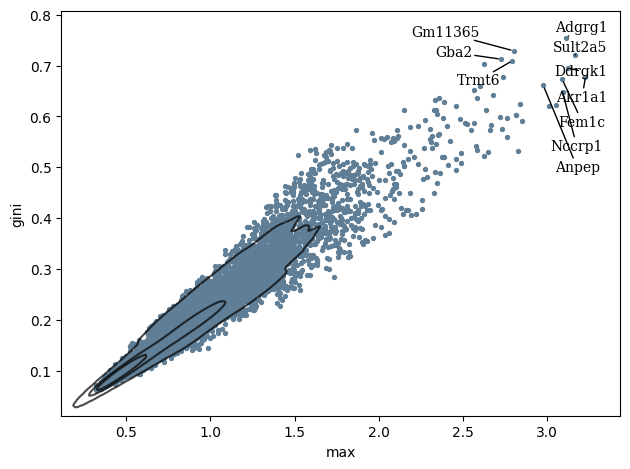

In [84]:
si.pl.entity_metrics(CG_adata_cmp_CG,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=False,
                     show_contour=True,
                     c='#607e95',
                    #  texts=marker_genes,
                     text_expand=(2,1.5))

In [85]:
df_softmax_CG = pd.DataFrame(
    data=CG_adata_cmp_CG.layers['softmax'], 
    index=CG_adata_cmp_CG.obs.index, 
    columns=CG_adata_cmp_CG.var.index
)


In [86]:
rna_simba_name = '../results/03/rna_simba.celltype_label.ep500_lr0.1'
rna_poincare_coord_fn = f'{rna_simba_name}.poincare_coord.labeled.csv'
rna_poincare_coord_df = pd.read_csv(rna_poincare_coord_fn)

rna_poincare_coord_df.columns


Index(['x', 'y', 'labels'], dtype='object')

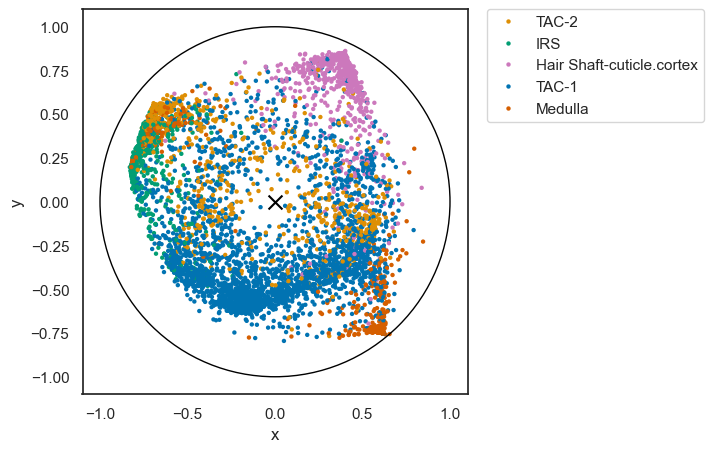

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
zoom1_coordinates = np.array(linear_scale(rna_poincare_coord_df[['x', 'y']].values))
zoom_rna_poincare_coord_df = rna_poincare_coord_df.copy()
zoom_rna_poincare_coord_df[['x', 'y']] = zoom1_coordinates
sns.scatterplot(data=zoom_rna_poincare_coord_df, x='x', y='y', hue='labels', palette=celltype_colors, s=10, linewidth=0, ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.scatter([0], [0], color='black', s=100, marker='x')
ax.set_aspect('equal')
circle = plt.Circle((0, 0), radius=1,  fc='none', color='black')
ax.add_patch(circle)
plt.show()


In [139]:
rna_features_df = pd.read_csv(f"../results/02/rna_simba.celltype_label.csv", sep=',')
rna_poincare_coord_rot_df = get_rotated_poincare_coord(rna_poincare_coord_df, rna_features_df, root="TAC-1")
rna_poincare_coord_rot_df.head()


x         y                     labels
0  0.039894  0.131902                      TAC-2
1 -0.141834  0.068099                        IRS
2  0.131826  0.401901  Hair Shaft-cuticle.cortex
3  0.047645  0.115681                      TAC-1
4 -0.029890 -0.116072                      TAC-1

In [138]:
(CG_adata_cmp_CG.var['gini'] > 0.7).sum()

6

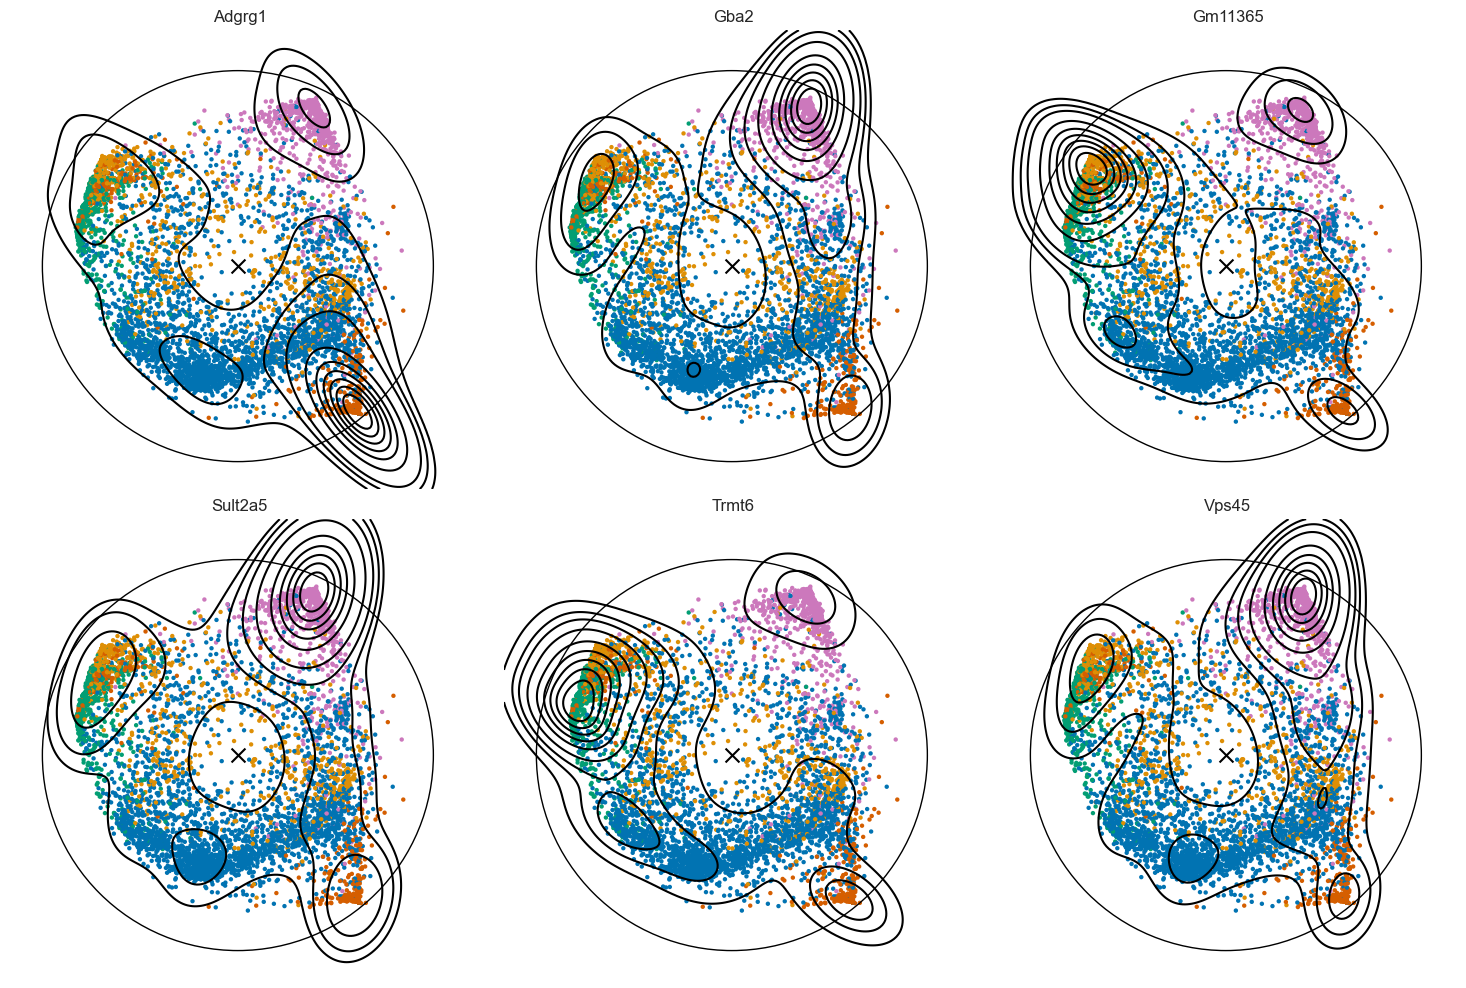

In [157]:
top_peaks = CG_adata_cmp_CG.var[CG_adata_cmp_CG.var['gini'] > 0.7].index
fig, axes = plt.subplots(nrows=int(len(top_peaks) / 3), ncols=3, figsize=(15, 10))
flat_axes = axes.flatten()
for i, peak in enumerate(top_peaks):
    sns.scatterplot(
        data=zoom_rna_poincare_coord_df, x='x', y='y', 
        hue='labels', palette=celltype_colors, s=10,
        ax=flat_axes[i], linewidth=0
    )

    sns.kdeplot(
        data=zoom_rna_poincare_coord_df, x='x', y='y', 
        weights=df_softmax_CG[peak].values, 
        ax=flat_axes[i],
        s=10,
        color='black'
    )
    flat_axes[i].get_legend().remove()
    flat_axes[i].scatter([0], [0], color='black', s=100, marker='x')
    flat_axes[i].set_aspect('equal')
    flat_axes[i].set_title(peak)
    circle = plt.Circle((0, 0), radius=1,  fc='none', color='black')
    flat_axes[i].add_patch(circle)
    flat_axes[i].axis('off')

plt.tight_layout()
plt.show()


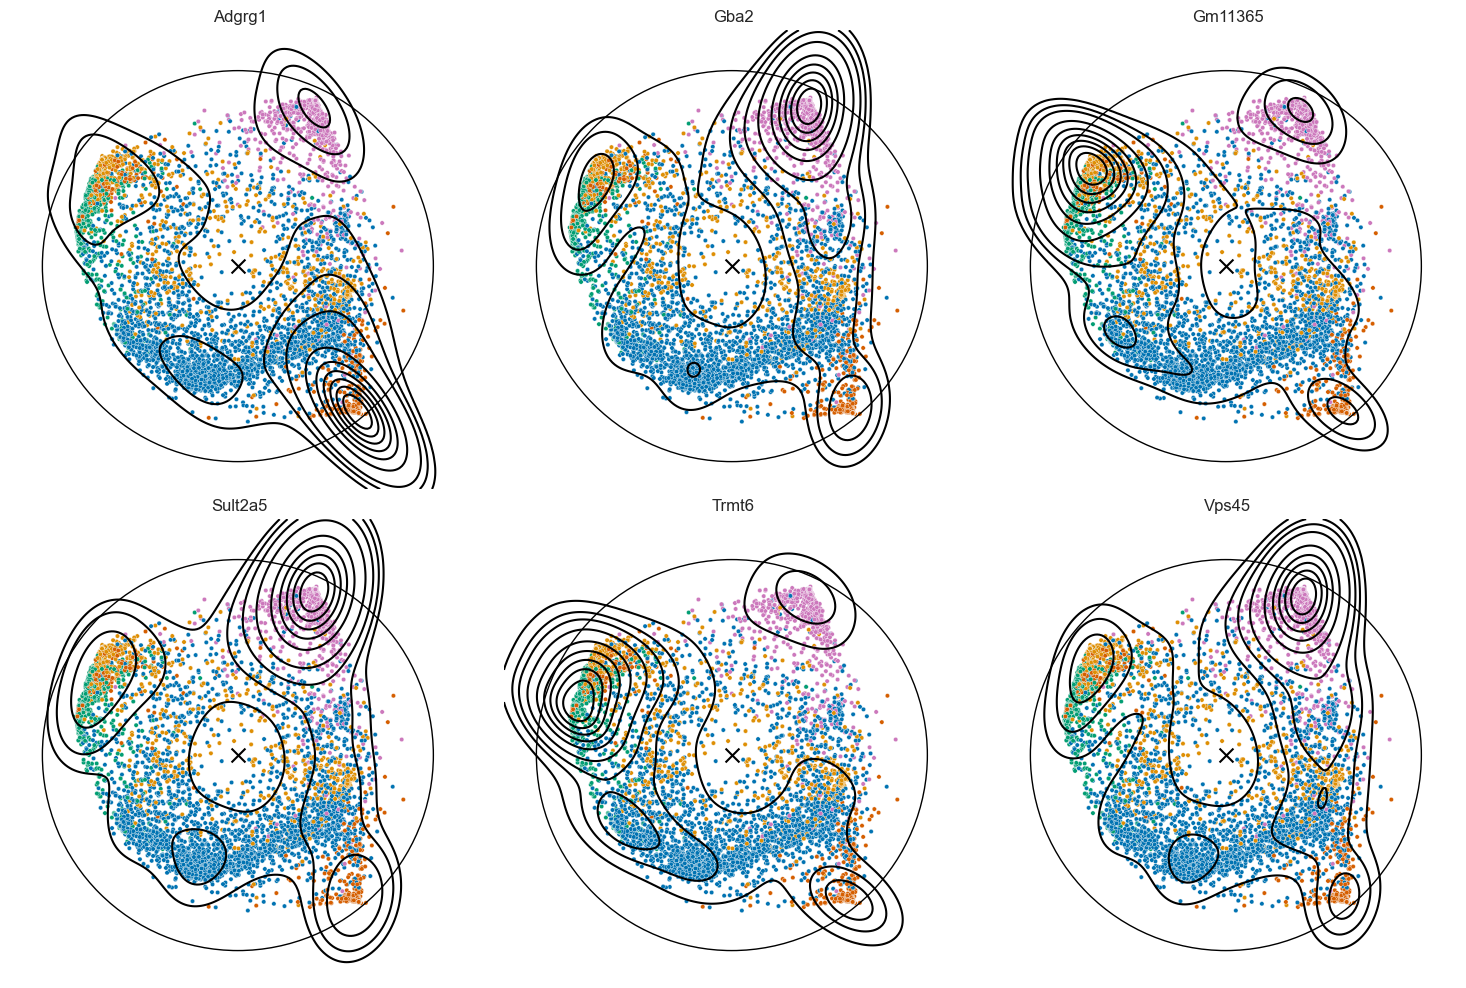

In [158]:
top_peaks = CG_adata_cmp_CG.var[CG_adata_cmp_CG.var['gini'] > 0.7].index
fig, axes = plt.subplots(nrows=int(len(top_peaks) / 3), ncols=3, figsize=(15, 10))
flat_axes = axes.flatten()
for i, peak in enumerate(top_peaks):
    sns.scatterplot(
        data=zoom_rna_poincare_coord_df, x='x', y='y', 
        hue='labels', palette=celltype_colors, s=10,
        ax=flat_axes[i]
    )

    sns.kdeplot(
        data=zoom_rna_poincare_coord_df, x='x', y='y', 
        weights=df_softmax_CG[peak].values, 
        ax=flat_axes[i],
        s=10,
        color='black'
    )
    flat_axes[i].get_legend().remove()
    flat_axes[i].scatter([0], [0], color='black', s=100, marker='x')
    flat_axes[i].set_aspect('equal')
    flat_axes[i].set_title(peak)
    circle = plt.Circle((0, 0), radius=1,  fc='none', color='black')
    flat_axes[i].add_patch(circle)
    flat_axes[i].axis('off')

plt.tight_layout()
plt.show()


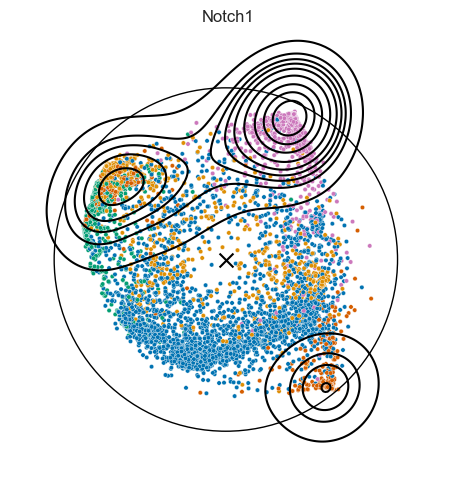

In [159]:
notch1_peak = 'Notch1'
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# flat_axes = axes.flatten()

sns.scatterplot(
    data=zoom_rna_poincare_coord_df, x='x', y='y', 
    hue='labels', palette=celltype_colors, s=10,
    ax=ax
)

threshold = df_softmax_CG[notch1_peak].quantile(0.9)
top_cells_idx = df_softmax_CG.reset_index().query(f'{notch1_peak} > @threshold').index

sns.kdeplot(
    data=zoom_rna_poincare_coord_df.loc[top_cells_idx], x='x', y='y', 
    weights=df_softmax_CG.iloc[top_cells_idx][notch1_peak].values, 
    ax=ax,
    s=10,
    color='black'
)
ax.get_legend().remove()
ax.scatter([0], [0], color='black', s=100, marker='x')
ax.set_aspect('equal')
ax.set_title(notch1_peak)
circle = plt.Circle((0, 0), radius=1,  fc='none', color='black')
ax.add_patch(circle)
ax.axis('off')

plt.tight_layout()
plt.show()


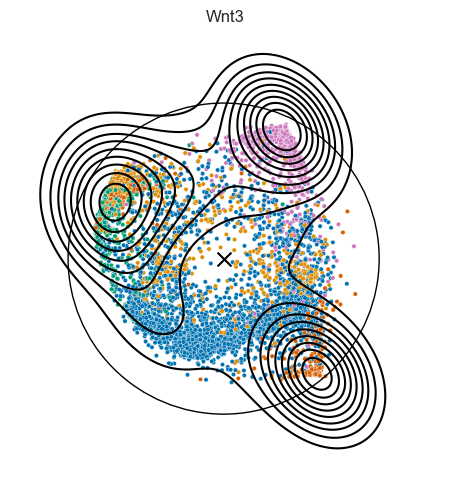

In [160]:
wnt3_peak = 'Wnt3'
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# flat_axes = axes.flatten()

sns.scatterplot(
    data=zoom_rna_poincare_coord_df, x='x', y='y', 
    hue='labels', palette=celltype_colors, s=10,
    ax=ax
)

threshold = df_softmax_CG[wnt3_peak].quantile(0.9)
top_cells_idx = df_softmax_CG.reset_index().query(f'{wnt3_peak} > @threshold').index

sns.kdeplot(
    data=zoom_rna_poincare_coord_df.loc[top_cells_idx], x='x', y='y', 
    weights=df_softmax_CG.iloc[top_cells_idx][wnt3_peak].values, 
    ax=ax,
    s=10,
    color='black'
)
ax.get_legend().remove()
ax.scatter([0], [0], color='black', s=100, marker='x')
ax.set_aspect('equal')
ax.set_title(wnt3_peak)
circle = plt.Circle((0, 0), radius=1,  fc='none', color='black')
ax.add_patch(circle)
ax.axis('off')

plt.tight_layout()
plt.show()


# ATAC - SIMBA

In [4]:
# load in graph ('graph0') info
si.load_graph_stats(path=f'../results/01/pbg/graph_CP/')
# load in model info for ('graph0')
si.load_pbg_config(path=f'../results/01/pbg/graph_CP/model/')


In [5]:
CP_dict_adata = si.read_embedding()
CP_adata_C = CP_dict_adata['C']
CP_adata_P = CP_dict_adata['P']
CP_adata_C.obs['celltype'] = adata_CP[CP_adata_C.obs_names,:].obs['celltype'].copy()
CP_adata_P.obs = adata_CP.var.copy()

In [12]:
CP_adata_cmp_CP = si.tl.compare_entities(adata_ref=CP_adata_C, adata_query=CP_adata_P[CP_adata_P.obs['TSSidx'] == True])

In [80]:
CP_adata_cmp_CP_fn = f"{workdir}/atac_simba.celltype_label.ep500_lr0.1.cmp_CP.h5ad"
print(CP_adata_cmp_CP_fn)
CP_adata_cmp_CP.write(CP_adata_cmp_CP_fn)


../results/04/atac_simba.celltype_label.ep500_lr0.1.cmp_CP.h5ad


<Axes: >

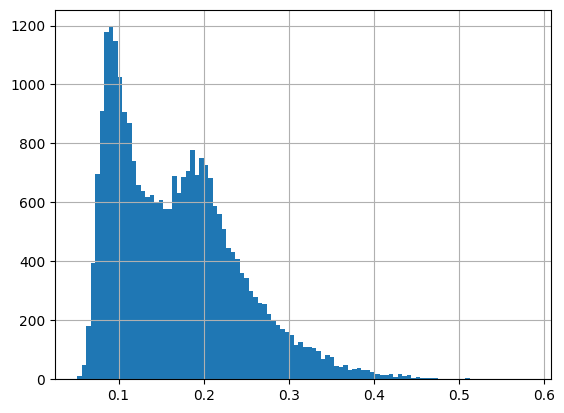

In [22]:
CP_adata_cmp_CP.var['gini'].hist(bins=100)

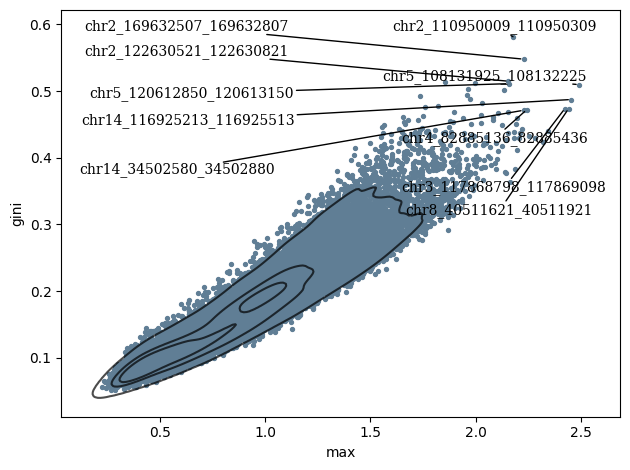

In [18]:
si.pl.entity_metrics(CP_adata_cmp_CP,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=False,
                     show_contour=True,
                     c='#607e95',
                    #  texts=marker_genes,
                     text_expand=(2,1.5))

In [13]:
df_softmax_CP = pd.DataFrame(
    data=CP_adata_cmp_CP.layers['softmax'], 
    index=CP_adata_cmp_CP.obs.index, 
    columns=CP_adata_cmp_CP.var.index
)


In [28]:
CP_adata_cmp_CP.var[CP_adata_cmp_CP.var['gini'] > 0.5].index

chr      start        end  width strand  TSSidx  \
chr1_161394971_161395271  chr1  161394971  161395271    301      *    True   
chr2_110950009_110950309  chr2  110950009  110950309    301      *    True   
chr2_122630521_122630821  chr2  122630521  122630821    301      *    True   
chr2_169632507_169632807  chr2  169632507  169632807    301      *    True   
chr4_89311676_89311976    chr4   89311676   89311976    301      *    True   
chr5_108131925_108132225  chr5  108131925  108132225    301      *    True   
chr5_120612850_120613150  chr5  120612850  120613150    301      *    True   
chr6_83054442_83054742    chr6   83054442   83054742    301      *    True   
chr8_111145540_111145840  chr8  111145540  111145840    301      *    True   

                          Enhanceridx                   Gene           peaks  \
chr1_161394971_161395271        False                 Pabpc5  chr1_161394971   
chr2_110950009_110950309        False                Gm15413  chr2_110950009   
chr2_122630521_122630821        False                  Epcam  chr2_122630521   
chr2_169632507_169632807        False                   Tbca  chr2_169632507   
chr4_89311676_89311976          False                    Otc   chr4_89311676   
chr5_108131925_108132225        False                 Kif21a  chr5_108131925   
chr5_120612850_120613150        False                   Pawr  chr5_120612850   
chr6_83054442_83054742          False                   Per1   chr6_83054442   
chr8_111145540_111145840        False  mir-3075|mmu-mir-3075  chr8_111145540   

                          n_counts  n_cells  pct_cells  top_pcs       max  \
chr1_161394971_161395271      13.0       13   0.002020     True  1.996903   
chr2_110950009_110950309      40.0       38   0.005904     True  2.177368   
chr2_122630521_122630821     412.0      388   0.060286     True  2.156169   
chr2_169632507_169632807      92.0       90   0.013984     True  2.227710   
chr4_89311676_89311976       126.0      119   0.018490     True  2.134880   
chr5_108131925_108132225     617.0      583   0.090584     True  2.490667   
chr5_120612850_120613150    1864.0     1539   0.239124     True  2.157159   
chr6_83054442_83054742      1098.0      965   0.149938     True  1.854290   
chr8_111145540_111145840     633.0      579   0.089963     True  1.962287   

                               std      gini   entropy  
chr1_161394971_161395271  0.852202  0.511506  8.290806  
chr2_110950009_110950309  1.020374  0.581699  8.147289  
chr2_122630521_122630821  0.868937  0.514853  8.281179  
chr2_169632507_169632807  0.906985  0.547951  8.200327  
chr4_89311676_89311976    0.824637  0.502054  8.297948  
chr5_108131925_108132225  0.793424  0.509740  8.213305  
chr5_120612850_120613150  0.824793  0.511189  8.266582  
chr6_83054442_83054742    0.904854  0.513570  8.311712  
chr8_111145540_111145840  0.862532  0.502741  8.320880

In [29]:
df_softmax_CP[CP_adata_cmp_CP.var[CP_adata_cmp_CP.var['gini'] > 0.5].index]

chr1_161394971_161395271  \
Trial60.skin.R1.04.R2.90.R3.45.P1.55                  0.000090   
Trial60.skin.R1.27.R2.05.R3.44.P1.56                  0.000715   
Trial60.skin.R1.65.R2.85.R3.21.P1.54                  0.000089   
Trial60.skin.R1.50.R2.14.R3.44.P1.56                  0.000068   
Trial60.skin.R1.61.R2.23.R3.61.P1.55                  0.000269   
...                                                        ...   
Trial60.skin.R1.90.R2.44.R3.40.P1.55                  0.000062   
Trial60.skin.R1.36.R2.93.R3.55.P1.55                  0.000041   
Trial60.skin.R1.13.R2.68.R3.67.P1.55                  0.000088   
Trial60.skin.R1.69.R2.67.R3.05.P1.53                  0.000982   
Trial60.skin.R1.75.R2.17.R3.69.P1.56                  0.000357   

                                      chr2_110950009_110950309  \
Trial60.skin.R1.04.R2.90.R3.45.P1.55                  0.000055   
Trial60.skin.R1.27.R2.05.R3.44.P1.56                  0.000980   
Trial60.skin.R1.65.R2.85.R3.21.P1.54                  0.000032   
Trial60.skin.R1.50.R2.14.R3.44.P1.56                  0.000059   
Trial60.skin.R1.61.R2.23.R3.61.P1.55                  0.000399   
...                                                        ...   
Trial60.skin.R1.90.R2.44.R3.40.P1.55                  0.000058   
Trial60.skin.R1.36.R2.93.R3.55.P1.55                  0.000038   
Trial60.skin.R1.13.R2.68.R3.67.P1.55                  0.000120   
Trial60.skin.R1.69.R2.67.R3.05.P1.53                  0.001864   
Trial60.skin.R1.75.R2.17.R3.69.P1.56                  0.000420   

                                      chr2_122630521_122630821  \
Trial60.skin.R1.04.R2.90.R3.45.P1.55                  0.000106   
Trial60.skin.R1.27.R2.05.R3.44.P1.56                  0.000408   
Trial60.skin.R1.65.R2.85.R3.21.P1.54                  0.000062   
Trial60.skin.R1.50.R2.14.R3.44.P1.56                  0.000046   
Trial60.skin.R1.61.R2.23.R3.61.P1.55                  0.000512   
...                                                        ...   
Trial60.skin.R1.90.R2.44.R3.40.P1.55                  0.000052   
Trial60.skin.R1.36.R2.93.R3.55.P1.55                  0.000047   
Trial60.skin.R1.13.R2.68.R3.67.P1.55                  0.000088   
Trial60.skin.R1.69.R2.67.R3.05.P1.53                  0.000452   
Trial60.skin.R1.75.R2.17.R3.69.P1.56                  0.000252   

                                      chr2_169632507_169632807  \
Trial60.skin.R1.04.R2.90.R3.45.P1.55                  0.000114   
Trial60.skin.R1.27.R2.05.R3.44.P1.56                  0.000527   
Trial60.skin.R1.65.R2.85.R3.21.P1.54                  0.000117   
Trial60.skin.R1.50.R2.14.R3.44.P1.56                  0.000069   
Trial60.skin.R1.61.R2.23.R3.61.P1.55                  0.000415   
...                                                        ...   
Trial60.skin.R1.90.R2.44.R3.40.P1.55                  0.000051   
Trial60.skin.R1.36.R2.93.R3.55.P1.55                  0.000032   
Trial60.skin.R1.13.R2.68.R3.67.P1.55                  0.000101   
Trial60.skin.R1.69.R2.67.R3.05.P1.53                  0.000926   
Trial60.skin.R1.75.R2.17.R3.69.P1.56                  0.000298   

                                      chr4_89311676_89311976  \
Trial60.skin.R1.04.R2.90.R3.45.P1.55                0.000093   
Trial60.skin.R1.27.R2.05.R3.44.P1.56                0.000608   
Trial60.skin.R1.65.R2.85.R3.21.P1.54                0.000131   
Trial60.skin.R1.50.R2.14.R3.44.P1.56                0.000069   
Trial60.skin.R1.61.R2.23.R3.61.P1.55                0.000167   
...                                                      ...   
Trial60.skin.R1.90.R2.44.R3.40.P1.55                0.000046   
Trial60.skin.R1.36.R2.93.R3.55.P1.55                0.000044   
Trial60.skin.R1.13.R2.68.R3.67.P1.55                0.000104   
Trial60.skin.R1.69.R2.67.R3.05.P1.53                0.001553   
Trial60.skin.R1.75.R2.17.R3.69.P1.56                0.000423   

                                      chr5_108131925_108132225  \
Trial60.skin.R1.04.R2.90.R3.45.

In [16]:
atac_simba_name = '../results/03/atac_simba.celltype_label.ep500_lr0.1'
atac_poincare_coord_fn = f'{atac_simba_name}.poincare_coord.labeled.csv'
atac_poincare_coord_df = pd.read_csv(atac_poincare_coord_fn)

atac_poincare_coord_df.columns


Index(['x', 'y', 'labels'], dtype='object')

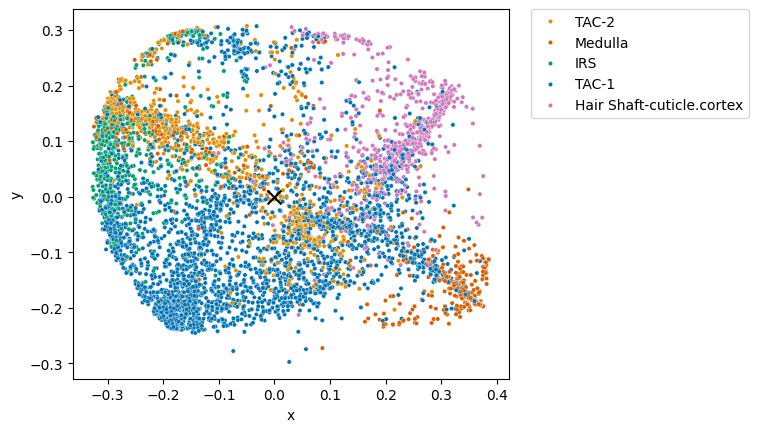

In [41]:
sns.scatterplot(data=atac_poincare_coord_df, x='x', y='y', hue='labels', palette=celltype_colors, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.scatter([0], [0], color='black', s=100, marker='x')
plt.gca().set_aspect('equal')


In [161]:
zoom1_atac_poincare_coord_df = atac_poincare_coord_df.copy()
zoom1_atac_poincare_coord_df[['x', 'y']] = np.array(linear_scale(atac_poincare_coord_df[['x', 'y']].values))

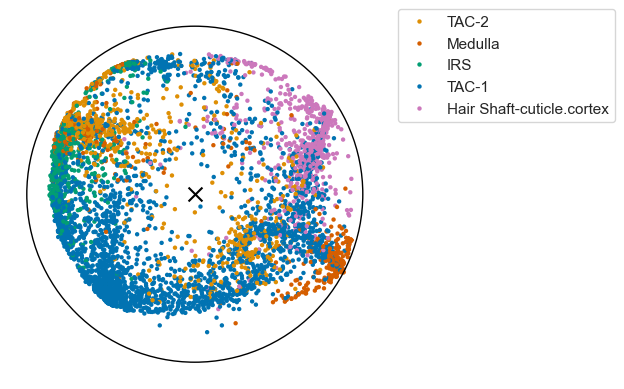

In [163]:
sns.scatterplot(data=zoom1_atac_poincare_coord_df, x='x', y='y', hue='labels', palette=celltype_colors, s=10, linewidth=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.scatter([0], [0], color='black', s=100, marker='x')
plt.gca().set_aspect('equal')
circle = plt.Circle((0, 0), radius=1,  fc='none', color='black')
plt.gca().add_patch(circle)
plt.gca().axis('off')
plt.show()

In [45]:
atac_poincare_coord_df

x         y                     labels
0    -0.299965  0.169767                      TAC-2
1     0.368026 -0.193022                    Medulla
2    -0.272425  0.072629                        IRS
3    -0.293353 -0.077048                      TAC-1
4     0.268896  0.121068  Hair Shaft-cuticle.cortex
...        ...       ...                        ...
6431 -0.066410  0.278053                      TAC-1
6432 -0.221127 -0.141556                      TAC-1
6433 -0.050470 -0.099769                      TAC-1
6434  0.370197 -0.194708                    Medulla
6435  0.367812 -0.193432                    Medulla

[6436 rows x 3 columns]

In [64]:
CP_adata_cmp_CP.var[CP_adata_cmp_CP.var['Gene'].str.contains('Notch1')]

chr      start        end  width strand  TSSidx  \
chrX_60403973_60404273    chrX   60403973   60404273    301      *    True   
chrX_137038054_137038354  chrX  137038054  137038354    301      *    True   
chrX_159988074_159988374  chrX  159988074  159988374    301      *    True   

                          Enhanceridx    Gene           peaks  n_counts  \
chrX_60403973_60404273          False  Notch1   chrX_60403973     476.0   
chrX_137038054_137038354        False  Notch1  chrX_137038054     290.0   
chrX_159988074_159988374        False  Notch1  chrX_159988074     270.0   

                          n_cells  pct_cells  top_pcs       max       std  \
chrX_60403973_60404273        450   0.069919     True  0.678912  0.202481   
chrX_137038054_137038354      277   0.043039     True  1.057872  0.337579   
chrX_159988074_159988374      262   0.040709     True  0.463535  0.199176   

                              gini   entropy  
chrX_60403973_60404273    0.115709  8.747465  
chrX_137038054_137038354  0.192852  8.707104  
chrX_159988074_159988374  0.110926  8.750397

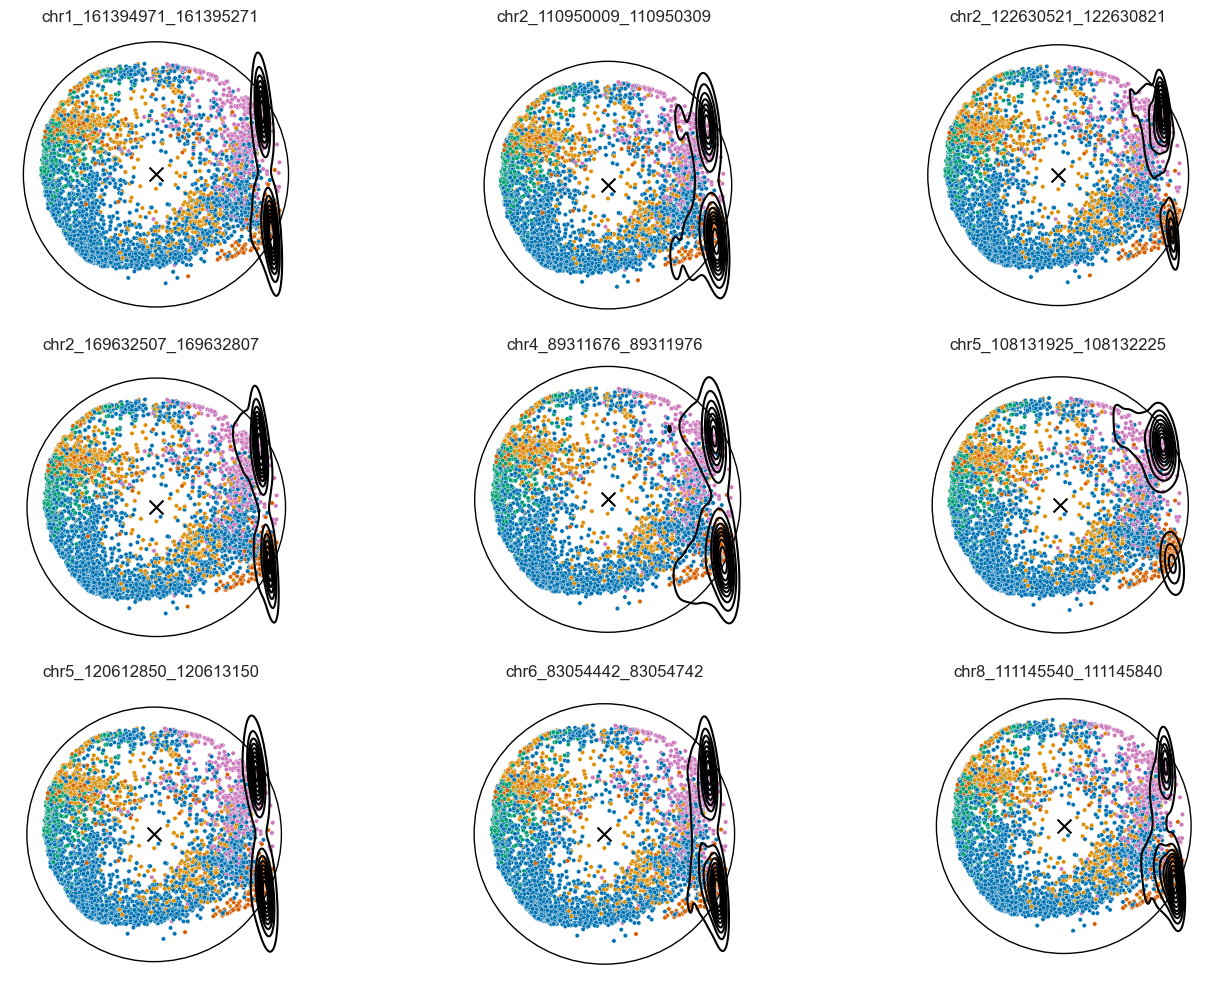

In [164]:
top_peaks = CP_adata_cmp_CP.var[CP_adata_cmp_CP.var['gini'] > 0.5].index
fig, axes = plt.subplots(nrows=int(len(top_peaks) / 3), ncols=3, figsize=(15, 10))
flat_axes = axes.flatten()
for i, peak in enumerate(top_peaks):
    sns.scatterplot(
        data=zoom1_atac_poincare_coord_df, x='x', y='y', 
        hue='labels', palette=celltype_colors, s=10,
        ax=flat_axes[i]
    )

    threshold = df_softmax_CP[peak].quantile(0.9)
    top_cells_idx = df_softmax_CP.reset_index().query(f'{peak} > @threshold').index

    sns.kdeplot(
        data=zoom1_atac_poincare_coord_df.loc[top_cells_idx], x='x', y='y', 
        weights=df_softmax_CP.iloc[top_cells_idx][peak].values, 
        ax=flat_axes[i],
        s=10,
        color='black'
    )
    flat_axes[i].get_legend().remove()
    flat_axes[i].scatter([0], [0], color='black', s=100, marker='x')
    flat_axes[i].set_aspect('equal')
    flat_axes[i].set_title(peak)
    circle = plt.Circle((0, 0), radius=1,  fc='none', color='black')
    flat_axes[i].add_patch(circle)
    flat_axes[i].axis('off')

plt.tight_layout()
plt.show()


In [170]:
CP_adata_cmp_CP.var.query('Gene.str.contains("Notch")')

chr      start        end  width strand  TSSidx  \
chr11_120347228_120347528  chr11  120347228  120347528    301      *    True   
chr16_30389285_30389585    chr16   30389285   30389585    301      *    True   
chr16_85550196_85550496    chr16   85550196   85550496    301      *    True   
chr17_32966008_32966308    chr17   32966008   32966308    301      *    True   
chr17_33782056_33782356    chr17   33782056   33782356    301      *    True   
chr17_74527315_74527615    chr17   74527315   74527615    301      *    True   
chr4_45972601_45972901      chr4   45972601   45972901    301      *    True   
chr4_141301124_141301424    chr4  141301124  141301424    301      *    True   
chr5_45520050_45520350      chr5   45520050   45520350    301      *    True   
chr5_134183920_134184220    chr5  134183920  134184220    301      *    True   
chrX_60403973_60404273      chrX   60403973   60404273    301      *    True   
chrX_137038054_137038354    chrX  137038054  137038354    301      *    True   
chrX_159988074_159988374    chrX  159988074  159988374    301      *    True   

                           Enhanceridx    Gene            peaks  n_counts  \
chr11_120347228_120347528        False  Notch3  chr11_120347228      82.0   
chr16_30389285_30389585          False  Notch4   chr16_30389285     101.0   
chr16_85550196_85550496          False  Notch2   chr16_85550196      16.0   
chr17_32966008_32966308          False  Notch2   chr17_32966008     251.0   
chr17_33782056_33782356          False  Notch2   chr17_33782056      88.0   
chr17_74527315_74527615          False  Notch2   chr17_74527315     184.0   
chr4_45972601_45972901           False  Notch2    chr4_45972601     222.0   
chr4_141301124_141301424         False  Notch3   chr4_141301124     637.0   
chr5_45520050_45520350           False  Notch2    chr5_45520050     354.0   
chr5_134183920_134184220         False  Notch2   chr5_134183920     363.0   
chrX_60403973_60404273           False  Notch1    chrX_60403973     476.0   
chrX_137038054_137038354         False  Notch1   chrX_137038054     290.0   
chrX_159988074_159988374         False  Notch1   chrX_159988074     270.0   

                           n_cells  pct_cells  top_pcs       max       std  \
chr11_120347228_120347528       81   0.012585     True  0.991710  0.378169   
chr16_30389285_30389585         99   0.015382     True  0.598100  0.180498   
chr16_85550196_85550496         16   0.002486     True  0.558353  0.173792   
chr17_32966008_32966308        238   0.036979     True  0.989162  0.431848   
chr17_33782056_33782356         86   0.013362     True  0.647586  0.174236   
chr17_74527315_74527615        181   0.028123     True  1.232019  0.422151   
chr4_45972601_45972901         214   0.033250     True  0.723222  0.230831   
chr4_141301124_141301424       587   0.091206     True  1.022988  0.295477   
chr5_45520050_45520350         337   0.052362     True  1.333409  0.402487   
chr5_134183920_134184220       346   0.053760     True  0.674732  0.262881   
chrX_60403973_60404273         450   0.069919     True  0.678912  0.202481   
chrX_137038054_137038354       277   0.043039     True  1.057872  0.337579   
chrX_159988074_159988374       262   0.040709     True  0.463535  0.199176   

                               gini   entropy  
chr11_120347228_120347528  0.214830  8.695292  
chr16_30389285_30389585    0.100238  8.752673  
chr16_85550196_85550496    0.097730  8.753958  
chr17_32966008_32966308    0.244421  8.676017  
chr17_33782056_33782356    0.097228  8.753218  
chr17_74527315_74527615    0.242533  8.670764  
chr4_45972601_45972901     0.129539  8.741876  
chr4_141301124_141301424   0.171274  8.718894  
chr5_45520050_45520350     0.238458  8.668764  
chr5_134183920_134184220   0.147567  8.735387  
chrX_60403973_60404273     0.115709  8.747465  
chrX_137038054_137038354   0.192852  8.707104  
chrX_159988074_159988374   0.110926  8.750397

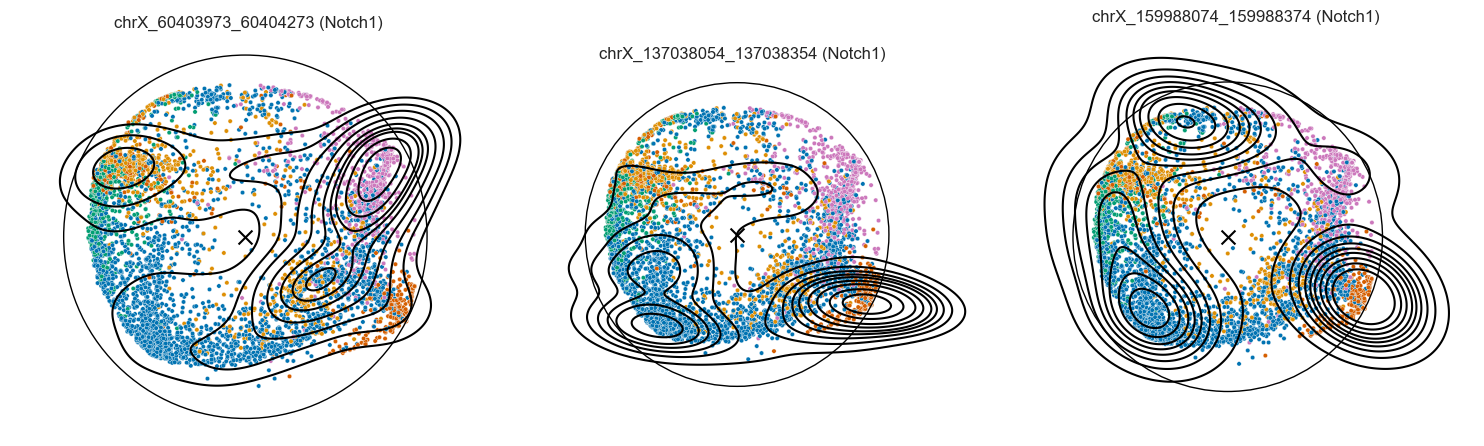

In [165]:
notch1_peaks = CP_adata_cmp_CP.var[CP_adata_cmp_CP.var['Gene'].str.contains('Notch1')].index

fig, axes = plt.subplots(nrows=int(len(notch1_peaks) / 3), ncols=3, figsize=(15, 10))
flat_axes = axes.flatten()
for i, peak in enumerate(notch1_peaks):
    sns.scatterplot(
        data=zoom1_atac_poincare_coord_df, x='x', y='y', 
        hue='labels', palette=celltype_colors, s=10,
        ax=flat_axes[i]
    )

    threshold = df_softmax_CP[peak].quantile(0.9)
    top_cells_idx = df_softmax_CP.reset_index().query(f'{peak} > @threshold').index

    sns.kdeplot(
        data=zoom1_atac_poincare_coord_df.loc[top_cells_idx], x='x', y='y', 
        weights=df_softmax_CP.iloc[top_cells_idx][peak].values, 
        ax=flat_axes[i],
        s=10,
        color='black'
    )
    flat_axes[i].get_legend().remove()
    flat_axes[i].scatter([0], [0], color='black', s=100, marker='x')
    flat_axes[i].set_aspect('equal')
    flat_axes[i].set_title(f'{peak} ({CP_adata_cmp_CP.var.loc[peak, "Gene"]})')
    circle = plt.Circle((0, 0), radius=1,  fc='none', color='black')
    flat_axes[i].add_patch(circle)
    flat_axes[i].axis('off')

plt.tight_layout()
plt.show()


In [171]:
CP_adata_cmp_CP.obs[] #.var[CP_adata_cmp_CP.var['Gene'].str.contains('Wnt3')]

AnnData object with n_obs × n_vars = 6436 × 27755
    obs: 'celltype'
    var: 'chr', 'start', 'end', 'width', 'strand', 'TSSidx', 'Enhanceridx', 'Gene', 'peaks', 'n_counts', 'n_cells', 'pct_cells', 'top_pcs', 'max', 'std', 'gini', 'entropy'
    layers: 'norm', 'softmax'

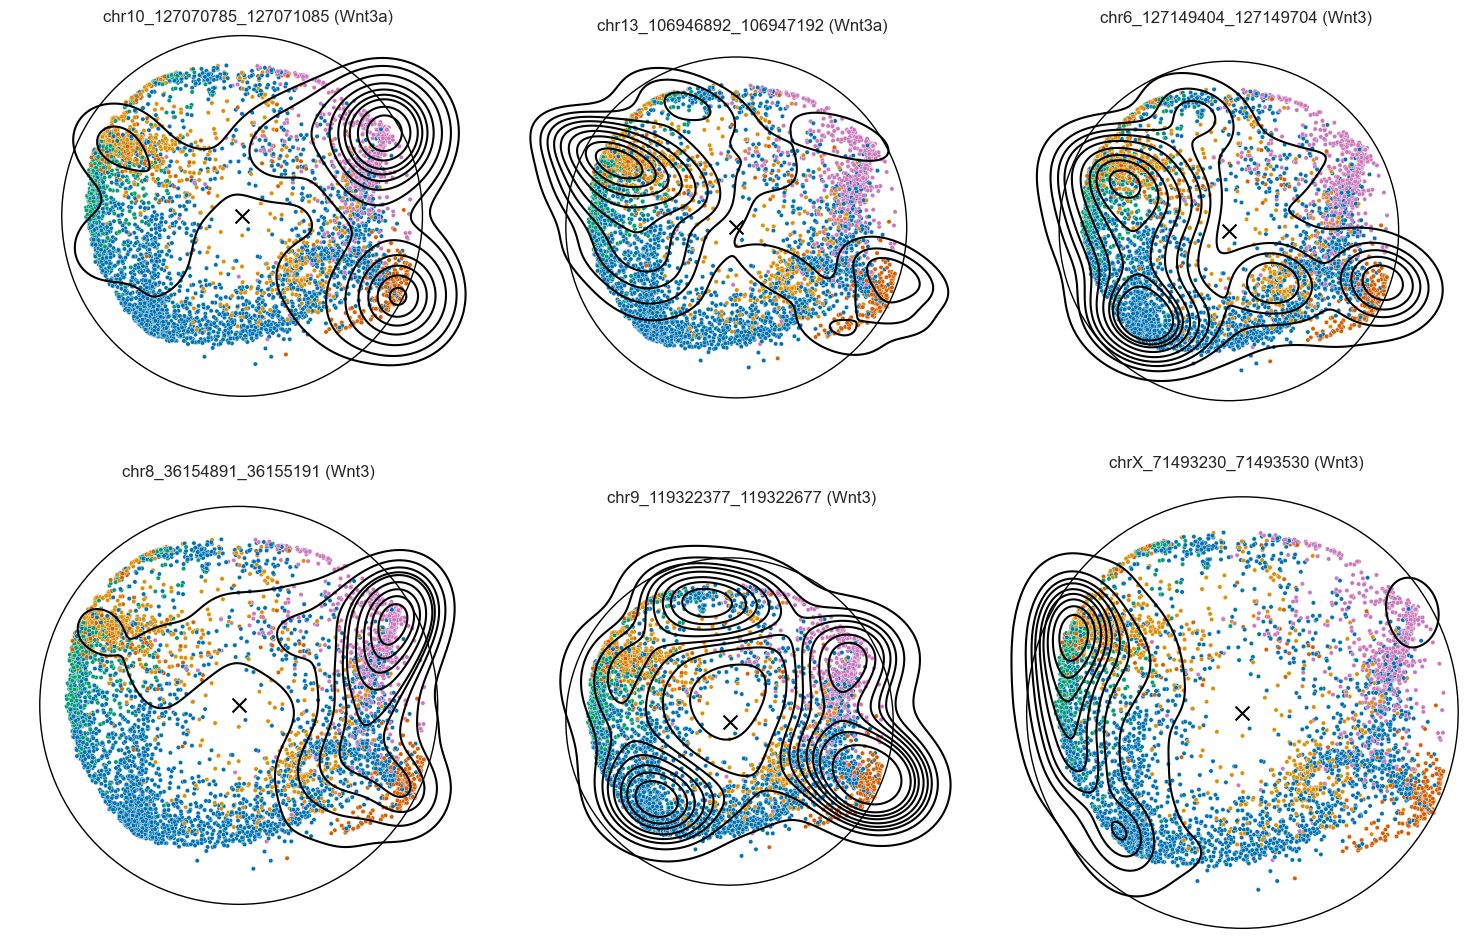

In [166]:
wnt3_peaks = CP_adata_cmp_CP.var[CP_adata_cmp_CP.var['Gene'].str.contains('Wnt3')].index

fig, axes = plt.subplots(nrows=int(len(wnt3_peaks) / 3), ncols=3, figsize=(15, 10))
flat_axes = axes.flatten()
for i, peak in enumerate(wnt3_peaks):
    sns.scatterplot(
        data=zoom1_atac_poincare_coord_df, x='x', y='y', 
        hue='labels', palette=celltype_colors, s=10,
        ax=flat_axes[i]
    )

    threshold = df_softmax_CP[peak].quantile(0.9)
    top_cells_idx = df_softmax_CP.reset_index().query(f'{peak} > @threshold').index

    sns.kdeplot(
        data=zoom1_atac_poincare_coord_df.loc[top_cells_idx], x='x', y='y', 
        weights=df_softmax_CP.iloc[top_cells_idx][peak].values, 
        ax=flat_axes[i],
        s=10,
        color='black'
    )
    flat_axes[i].get_legend().remove()
    flat_axes[i].scatter([0], [0], color='black', s=100, marker='x')
    flat_axes[i].set_aspect('equal')
    flat_axes[i].set_title(f'{peak} ({CP_adata_cmp_CP.var.loc[peak, "Gene"]})')
    circle = plt.Circle((0, 0), radius=1,  fc='none', color='black')
    flat_axes[i].add_patch(circle)
    flat_axes[i].axis('off')

plt.tight_layout()
plt.show()


In [173]:
adata_CP[CP_adata_C.obs_names,:].X.shape

(6436, 332987)

In [174]:
zoom1_atac_poincare_coord_df

x         y                     labels
0    -0.775168  0.438711                      TAC-2
1     0.875097 -0.458970                    Medulla
2    -0.772828  0.206039                        IRS
3    -0.804165 -0.211211                      TAC-1
4     0.746877  0.336274  Hair Shaft-cuticle.cortex
...        ...       ...                        ...
6431 -0.187168  0.783662                      TAC-1
6432 -0.648828 -0.415351                      TAC-1
6433 -0.224730 -0.444243                      TAC-1
6434  0.877797 -0.461684                    Medulla
6435  0.874588 -0.459945                    Medulla

[6436 rows x 3 columns]

In [183]:
adata_CP[CP_adata_C.obs_names,wnt3_peaks[0]].X.toarray().flatten()

224.0

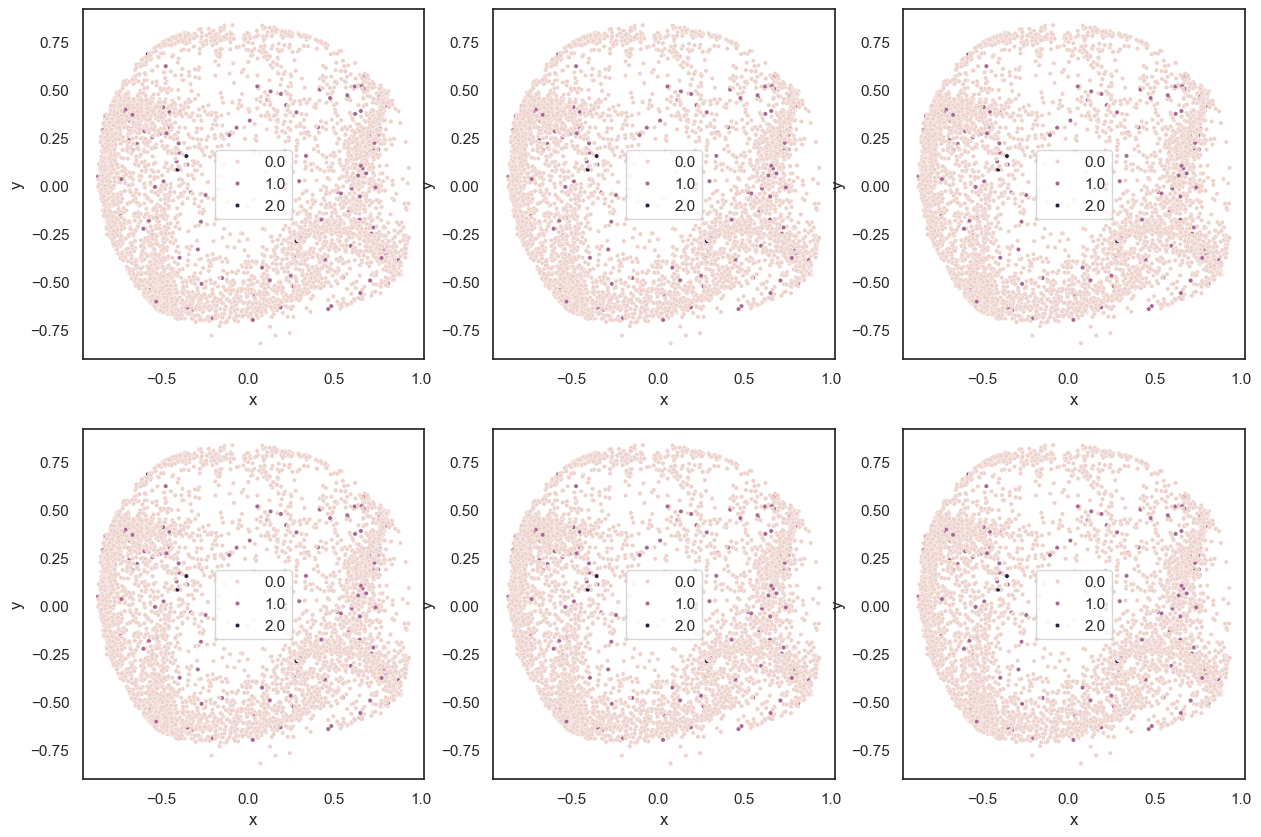

In [184]:
wnt3_peaks = CP_adata_cmp_CP.var[CP_adata_cmp_CP.var['Gene'].str.contains('Wnt3')].index

fig, axes = plt.subplots(nrows=int(len(wnt3_peaks) / 3), ncols=3, figsize=(15, 10))
flat_axes = axes.flatten()
for i, peak in enumerate(wnt3_peaks):
    sns.scatterplot(
        data=zoom1_atac_poincare_coord_df, x='x', y='y', 
        # hue='labels', palette=celltype_colors, 
        hue=adata_CP[CP_adata_C.obs_names,wnt3_peaks[0]].X.toarray().flatten(),
        s=10,
        ax=flat_axes[i]
    )